In [3]:
from os import path

print(path.abspath(" "))

/Users/collinsliu/jupyter/machine_learning/chapters/ 


# prepare data - mnist
1. two ways:<br>
> 1. sklearn fetch_openml <br>
> 2. download from official websites <br> arff format

## download
1. from scipy.io.arff import loadarff
2. url: 'https://www.openml.org/data/v1/download/52667/mnist_784.arff'
3. mnist_path = "../data/mnist_784.arff"
4. mnist_raw = loadarff(mnist_path)

## sklearn fetch

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784') 

In [6]:
mnist.details

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [64]:
# data description:
# X - 70000 28*28 ndarray,which is flatten into 784 (70000,784) DF
# y - 70000 labels from 0-9
X, y = mnist["data"], mnist["target"]
X.index

RangeIndex(start=0, stop=70000, step=1)

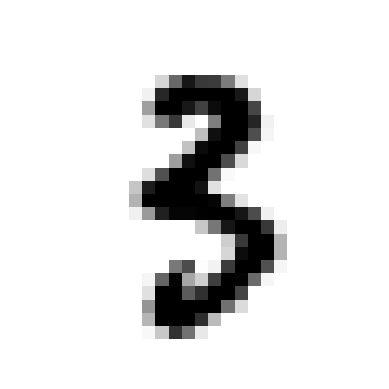

In [67]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

some_digit = X.iloc[45000]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image,  cmap=plt.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.grid(alpha=0)
plt.show()

In [69]:
y[45000]

'3'

## splitting train and test set
1. using index
2. permutation is needed - cause some ml model is order-sensitive

In [90]:
import numpy as np

np.random.RandomState(42)
shuffle_index = np.random.permutation(60000)
# again, note that X and y are stored in DF structure
X_train, X_test, y_train, y_test = X.iloc[:60000],X.iloc[60000:],y.iloc[:60000],y.iloc[60000:]
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

# train a binary classifier

In [122]:
# both numpy ndarray and pandas DataFrame allow masking
# being that sifting data with conditional judgement statement
###############################################################
# in this case, label will either be 1 or 0 denoting whether 
# digits belongs to 3 or not 3.
# note that category class will store class number as @@str@@
y_train_3 = y_train.apply(lambda x: x == '3')
y_test_3 = (y_test == "3")

In [123]:
# here we choose SGDClassifier
# numpy will automatically transfer boolean int int with following pattern
# True == 1 | False == 0
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3.apply(lambda x: int(x)))

SGDClassifier(random_state=42)

In [155]:
# sgd_clf.predict(some_digit.values.reshape(1,len(some_digit)))
sgd_clf.predict([some_digit])

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([1])

# evaluate classification result
## more controlled cross-validation
1. mannually implements cross_val_score
2. note that StratifiedKFold and KFold are mainly dealing with index
3. clone of one modle is necessary

In [171]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Stradified k-fold will split trains set and test set, but in multiple times 
# this feature is set in n_splits paramter
##############################################
# sklearn.model_selection could take DF or Se 
# yet make sure data type being made into @@int@@ or @@float@@
# not stayed in None or Object or Boolean
for train_index, test_index in skfolds.split(X_train, y_train_3.astype(int)):
    # clone is necessary
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_train_folds = y_train_3[train_index]
    y_test_fold = y_train_3[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds.apply(lambda x: int(x)))
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.6170833333333333
0.6839166666666666
0.8765833333333334
0.89375
0.7969166666666667


## typical cross validation

In [175]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3.astype(int), cv=5, scoring="accuracy")

array([0.96166667, 0.96116667, 0.95566667, 0.92058333, 0.96166667])

## accuracy problem
1. accuracy is not always the best evaluation measurement
2. for classification problems, more scoring methods are needed
3. confusion matrix will provide accuracy over different categories

In [188]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

sgd_clf_3 = SGDClassifier()
y_train_pred = cross_val_predict(sgd_clf_3, X_train, y_train_3.astype(int), cv=5)
confusion_matrix(y_train_3.astype(int),y_train_pred)

array([[52079,  1790],
       [ 1121,  5010]])

<table style="text-align:center;">
    <tr>
        <th></th>
        <th>pred non-3-class 0</th>
        <th>pred 3-class 1</th>
    </tr>
    <tr>
        <td>real non-3-class 0</td>
        <td>true non-3-class 0</td>
        <td>false positive</td>
    </tr>
    <tr>
        <td>real 3-class 1</td>
        <td>false negative</td>
        <td>true 3-class 1</td>
    </tr>
</table>

$$ important \space score 
\left\{
\begin{aligned}
    Precision & = & \frac{True \space Positive}{all \space Predicit \space 1s} & \\
    Recall & = & \frac{True \space Positive}{all \space Real \space 1s} & \\
    F1 & = & \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}
\end{aligned}
\right .
$$ 

In [190]:
from sklearn.metrics import precision_score, recall_score, f1_score
# y_train_pred could only return result of one fold, which may not 
# show the gerenral result of this model
precision_score(y_train_3.astype(int), y_train_pred)

0.736764705882353

In [185]:
recall_score(y_train_3.astype(int),y_train_pred)

0.7959549828739194

In [191]:
f1_score(y_train_3.astype(int), y_train_pred)

0.7748820663521769

In [192]:
print(y_train_pred.shape)

(60000,)


In [199]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# precision_recall will take two params
# first is the true labels, for methods to decide label assignments
# second is the prediction scores of SGDClassifier
y_scores = cross_val_predict(sgd_clf_3, X_train, y_train_3.astype(int),cv = 3,
                            method="decision_function")
precision, recalls, threshold = precision_recall_curve(y_train_3.astype(int), y_scores)

In [217]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],
             color="blue",ls='--',lw=1,label="Precision")
    plt.plot(thresholds, recalls[:-1],
             color="purple",ls='-',lw=1,label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.grid(alpha=0.4)
    plt.ylim([0,1])
    plt.xlim([-55000,55000])

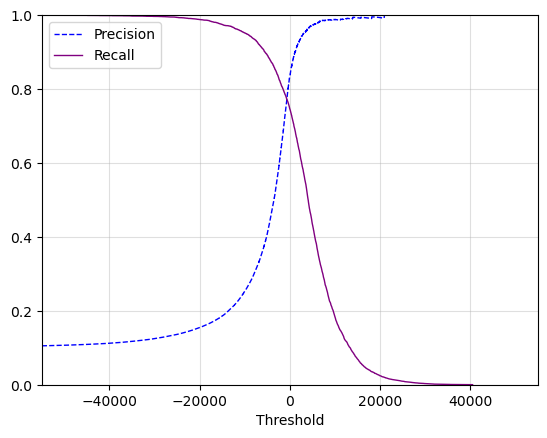

In [218]:
plot_precision_recall(precision, recalls, threshold)

# train a multiclass classifier